#### <strong>第三次作品：分類器的原理與評比實驗(資料一)</strong>
學號：410978002

姓名：謝元皓

<font color=skyblue>作品描述</font>：
 
本專題計畫執行這篇講義描述的分類器比較，即採用三種分類器分別對三組資料進行分類學習與測試。
其中分類器包括

- 多元羅吉斯回歸 (Multinomial Logistic Regression)
- 支援向量機 (Support Vector Machine)
- 神經網路 (Neural Network)

此作業包含共三筆資料，分成三份檔案呈現，每份資料分別運用三種分類器進行分類學習與測試。

<font color=skyblue>資料描述</font>：
第一筆為葡萄酒產地資料，來自 3 個產區，178 瓶葡萄酒，含 13 種葡萄酒成分
 <hr>

### 資料讀取
- 將資料拆成分成訓練資料跟測試資料。
- 先不對紅酒資料分組，單純考慮13個產區因子，因此排除最後一欄。
- 訓練和測試資料比例為 $4:1$。
- 先將原始資料標準化(必須將訓練和測試資料分開標準化)。
- 再運用PCA降維創造出主成分資料。
- 順便列印出訓練資料跟測試資料的大小。

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# Read data
Wine_df = pd.read_excel('Wine.xlsx')
X = np.array(Wine_df.iloc[:, :-1]) # 排 除 最 後 一 欄 標 籤
y = np.array(Wine_df.iloc[:, -1])
# Split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# 主成分分析 (PCA)
proportion = 0.8
pca = PCA(proportion)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape, y_test.shape) 
print(X_train_pca.shape)
print(X_test_pca.shape)



(142, 13) (142,)
(36, 13) (36,)
(142, 5)
(36, 5)


## 分類器一: 多元邏吉斯回歸
- 需使用套件 sklearn 中的 LogisticRegression
- 運用Cross validation 的方式，找出最佳參數。
- 需使用到sklearn 中 GridSearchCV套件。
- 找出最好參數後，再用此訓練及測試資料。
<hr> 


### step1 運用 Cross validation 的方式，找出最佳的參數
#### 套件介紹
1. LogisticRegression 為Scikit-learn庫中的Logistic Regression模型
2. GridSearchCV, StratifiedShuffleSpli 為 Scikit-learn庫中的網格搜索(GridSearchCV)和分層洗牌分割(StratifiedShuffleSplit)模組。網格搜索用於選擇最佳的超參數，分層洗牌分割用於交叉驗證。
3. datetime 為Python的datetime模組，用於處理日期和時間。


#### 程式碼解析
- 讀取 "Wine.xlsx"文件，並創建一個文件名，用於存儲網格搜索的結果。文件名的格式是"df_當前日期時間.csv"。

- 'opts = dict(tol = 1e-6, max_iter = int(1e6))': 這一行程式碼創建了一個包含Logistic Regression模型的參數的字典。tol是訓練的容忍度，max_iter是最大迭代次數。
- parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg','sag','saga'], 'C':[0.1, 1, 10]}: 這一行程式碼定義了要進行網格搜索的參數空間。solver是Logistic Regression模型的優化算法，C是正則化強度。

- cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0): 這一行程式碼創建了一個分層洗牌分割對象，用於交叉驗證。它將數據集分成5個部分，其中30%作為測試集。

- "grid = GridSearchCV(estimator=LogisticRegression(**opts), param_grid=parameters, cv=cv, scoring=['accuracy','f1_macro'], refit="accuracy")": 這一行程式碼創建了一個GridSearchCV對象，用於進行網格搜索。它使用了Logistic Regression模型，參數空間是parameters，交叉驗證方法是cv，評估指標包括準確率和f1_macro，並且最終使用準確率作為最佳模型的選擇標準。

- grid.fit(X_train, y_train): 這一行程式碼對訓練數據進行網格搜索，找到最佳的超參數組合。

- cv_logistic = pd.DataFrame(data = grid.cv_results_): 這一行程式碼將網格搜索的結果轉換為DataFrame格式。

- cv_logistic.to_csv(results_file): 這一行程式碼將DataFrame保存為CSV文件，文件名為之前創建的results_file。

- print(grid.best_params_): 這一行程式碼打印出最佳超參數的值。

- print(grid.best_score_): 這一行程式碼打印出在最佳超參數下的最佳模型得分。

- print(grid.best_estimator_): 這一行程式碼打印出最佳模型的具體信息，包括所使用的超參數。

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  GridSearchCV, \
                        StratifiedShuffleSplit

from datetime import datetime
df = pd.read_excel('Wine.xlsx')
# Get the current date and time
now = datetime.now()
# Format the date and time as a string
now_str = now.strftime("%Y_%m_%d_%H_%M_%S")
results_file = 'df' + now_str + '.csv'

opts = dict(tol = 1e-6, max_iter = int(1e6)) # parameters for LogisticRegression
parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg','sag','saga'], 
              'C':[0.1, 1, 10]} # parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, \
                            random_state=0) # 5-fold CV
grid = GridSearchCV(estimator=LogisticRegression(**opts), \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(X_train, y_train)
# grid.fit(X, y)
cv_logistic = pd.DataFrame(data = grid.cv_results_)
cv_logistic.to_csv(results_file)



d:\python_venv\ml_evnv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\python_venv\ml_evnv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [4]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)


{'C': 1, 'solver': 'lbfgs'}
0.9655172413793103
LogisticRegression(C=1, max_iter=1000000, tol=1e-06)


< 結果與討論 >
- 所列出最佳參數值為{C = 10, solver = lbfgs}
- 參數最佳得分為 94.88%
- 故我們需要用c=10，最大迭代次數為1000000，收斂值為1e-06
<hr>

### step2 測試資料之準確率回報
- 運用上一步找出最佳參數訓練資料，計算各項準確率

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# 初始化羅吉斯回歸分類器並使用上一步找出的最佳參數
logreg = LogisticRegression(C=1, solver='lbfgs',tol = 1e-6, max_iter = int(1e6), verbose=1)

# 使用原始資料進行訓練及測試
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
accuracy_orig = accuracy_score(y_test, y_pred)

# 使用主成分資料進行訓練及測試
logreg.fit(X_train_pca, y_train)
y_pred_pca = logreg.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

print("Accuracy using original data:", accuracy_orig)
print("Accuracy using principal components:", accuracy_pca)


Accuracy using original data: 0.9722222222222222
Accuracy using principal components: 0.9166666666666666


< 結果與討論 >
- 上述這段程式碼將使用原始資料和使用PCA降維後的主成分資料來訓練和測試多元羅吉斯回歸分類器。
- 它會列印出兩種情況下的準確率(原始資料的準確率為97.22%，主成分後的資料準確率為91.66%)
<hr>


## 分類器二: 支援向量機 (Support Vector Machine)
支持向量機 (Support Vector Machine, SVM) 是一種用於分類和回歸分析的機器學習方法。以下是 SVM 的原理概述：

1. **分類目標**：
   - SVM 的目標是找到一個最佳的超平面，可以將不同類別的數據分開。這個超平面被稱為分類邊界。

2. **超平面**：
   - 在二維空間中，超平面是一個直線；在更高維度的空間中，它是一個超平面。對於二分類問題，超平面將數據分成兩個部分，每一部分代表一個類別。

3. **支持向量**：
   - 支持向量是離超平面最近的數據點。這些數據點對於定義超平面是至關重要的。

4. **最大邊界**：
   - SVM 的目標是找到一個分類邊界，使得兩個類別的支持向量到分類邊界的距離最大化。這種最大化邊界的方法被稱為最大間隔分類。

5. **軟間隔和硬間隔**：
   - 在實際應用中，數據通常是非線性可分的。為了允許一些錯誤的分類，SVM 引入了軟間隔，這使得分類器更加鬆散，能夠更好地泛化到未見過的數據。相反，硬間隔 SVM 要求所有數據都正確分類。

6. **核函數**：
   - 當數據不是線性可分時，SVM 使用核函數將數據映射到更高維度的空間中，從而使得數據在該空間中變得線性可分。常見的核函數包括線性核、多項式核和高斯核。

7. **學習算法**：
   - SVM 通常使用優化算法，如序列最小優化 (Sequential Minimal Optimization, SMO) 或梯度下降，來找到最優的超平面。

8. **優點**：
   - SVM 在處理高維數據上效果良好，且對於特徵數量大於樣本數的情況也表現出色。它能夠處理非線性分類問題，並且對於較小的數據集也能夠給出較好的結果。

9. **缺點**：
   - SVM 的訓練時間可能較長，特別是在大型數據集上。對於非常大的數據集，核函數的計算也可能變得非常昂貴。

### step1 運用 Cross validation 的方式，找出最佳的參數
#### 套件介紹
1. SVC 是 Scikit-learn 中的支持向量機分類器，
2. GridSearchCV 是用於超參數優化的網格搜索類別，
3. StratifiedShuffleSplit 用於生成分層隨機分割的交叉驗證集，
4. datetime 是 Python 的日期和時間處理類別，
5. pandas 是 Python 中用於數據處理的庫。

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import  GridSearchCV, \
                        StratifiedShuffleSplit

from datetime import datetime
df = pd.read_excel('Wine.xlsx')
# Get the current date and time
now = datetime.now()
# Format the date and time as a string
now_str = now.strftime("%Y_%m_%d_%H_%M_%S")
results_file = 'df_svm' + now_str + '.csv'

opts = dict(tol = 1e-6, max_iter = int(1e6)) # parameters for LogisticRegression
parameters = {'kernel':['linear', 'rbf', 'poly', 'sigmoid'], 
              'C':[0.1, 1, 10]} # parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, \
                            random_state=0) # 5-fold CV
grid = GridSearchCV(estimator=SVC(**opts), \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy")
grid.fit(X_train, y_train)
# grid.fit(X, y)
cv_logistic = pd.DataFrame(data = grid.cv_results_)
cv_logistic.to_csv(results_file)



d:\python_venv\ml_evnv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
d:\python_venv\ml_evnv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
d:\python_venv\ml_evnv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
d:\python_venv\ml_evnv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [23]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'C': 0.1, 'kernel': 'linear'}
0.9448275862068967
SVC(C=0.1, kernel='linear', max_iter=1000000, tol=1e-06)


< 結果與討論 >
- 所列出最佳參數值為{C = 0.1, 'kernel'='linear'}
- 參數最佳得分為 94.48%
- 故我們需要用c=0.1，最大迭代次數為1000000，收斂值為1e-06
<hr>

### step2 測試資料之準確率回報
- 運用上一步找出最佳參數練資料，同時計算各項準確率

#### 程式碼解析
這段程式碼演示了如何使用 Scikit-learn 中的支持向量機 (SVM) 來進行分類任務，並使用 `classification_report` 函數生成分類報告。讓我們一步步來解釋它：

1. **導入必要的庫和類別**：
   ```python
   from sklearn.svm import SVC, LinearSVC
   from sklearn.metrics import classification_report
   ```
   這些語句導入了必要的庫和類別。`SVC` 是 Scikit-learn 中的支持向量機分類器，`LinearSVC` 是用於線性支持向量機的類別，`classification_report` 是用於生成分類報告的函數。

2. **設置模型參數**：
   ```python
   C = 0.1  # SVM regularization parameter
   opts = dict(C=C, tol=1e-6, max_iter=int(1e6))
   ```
   這裡設置了一個正則化參數 `C`，以及一些其他的 SVC 參數，如容忍度 `tol` 和最大迭代次數 `max_iter`。這些參數將用於初始化 SVC 分類器。

3. **初始化 SVC 分類器**：
   ```python
   clf_svm = SVC(kernel='linear', **opts)
   ```
   這行程式碼初始化了一個 SVC 分類器。`kernel` 參數指定了要使用的核函數，這裡使用線性核函數 ('linear')。`**opts` 將之前設置的參數傳遞給 SVC 分類器。

4. **模型訓練**：
   ```python
   clf_svm.fit(X_train, y_train)
   ```
   這行程式碼使用訓練集 `X_train` 和對應的標籤 `y_train` 來訓練 SVC 分類器。

5. **進行預測**：
   ```python
   predictions = clf_svm.predict(X_test)
   ```
   這行程式碼使用訓練好的 SVC 分類器對測試集 `X_test` 進行預測，並將預測結果存儲在 `predictions` 變量中。

6. **生成分類報告**：
   ```python
   print(classification_report(y_test, predictions))
   ```
   這行程式碼使用 `classification_report` 函數生成一個分類報告，該報告包含了精度、召回率、F1 值等指標，用於評估模型的性能。`y_test` 是測試集的真實標籤，`predictions` 是模型的預測結果。

In [9]:
#原始資料標準化後的生成分類報告
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
C = 0.1 # SVM regularization parameter
opts = dict(C = C, tol = 1e-6, max_iter = int(1e6))
clf_svm = SVC(kernel='linear', **opts)
clf_svm.fit(X_train_scaled, y_train)
predictions = clf_svm.predict(X_test_scaled)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        13

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [27]:
# 主成分資料的生成分類報告
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
C = 0.1 # SVM regularization parameter
opts = dict(C = C, tol = 1e-6, max_iter = int(1e6))
clf_svm = SVC(kernel='linear', **opts)
clf_svm.fit(X_train_pca, y_train)
predictions = clf_svm.predict(X_test_pca)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36



#### 各項指標的描述 
這是分類報告，用於評估支持向量機 (SVM) 分類器在測試集上的性能。以下是報告中各個指標的解釋：

1. **precision**（精度）：指的是在所有被分類為某類的樣本中，真正屬於該類別的樣本所占的比例。比如對類別1而言，精度為0.92，意味著有92%的真正屬於類別1的樣本被成功地分類為類別1。

2. **recall**（召回率）：指的是在所有真正屬於某類的樣本中，被正確分類為該類別的樣本所占的比例。比如對類別2而言，召回率為0.93，意味著有93%的真正屬於類別2的樣本被成功地分類為類別2。

3. **f1-score**（F1 值）：精度和召回率的加權調和平均值，是一個綜合考慮精度和召回率的指標。F1 值越高，模型的性能越好。

4. **support**（支援度）：每個類別在測試集中的樣本數量。

5. **accuracy**（準確率）：模型在測試集上的整體準確率，即所有正確預測的樣本數佔所有樣本數的比例。

6. **macro avg**（宏平均）：對所有類別的精度、召回率和 F1 值進行算術平均。它對每個類別的性能給予相同的權重，不考慮類別不平衡的問題。

7. **weighted avg**（加權平均）：對所有類別的精度、召回率和 F1 值進行加權平均，權重為每個類別的支援度（樣本數量）。這反映了不同類別在測試集中的重要性。
<hr>

## 分類器三: 神經網路 (Neural Network)

神經網路（Neural Network）是一種模仿人腦結構和功能的機器學習模型，通常用於解決分類和回歸問題。以下是神經網路的原理：

1. **神經元**：
   - 神經網路由神經元組成，每個神經元接收多個輸入，通過權重加權後，將它們與偏差相加並通過激活函數進行處理，最終產生輸出。

2. **權重**：
   - 權重是神經元對輸入的影響程度，它決定了每個輸入的重要性。神經網路通過學習過程中不斷調整權重來提高模型的性能。

3. **偏差**：
   - 偏差是神經元的一個常數項，它用於調整神經元的激活閾值，從而影響神經元的輸出。

4. **激活函數**：
   - 激活函數是神經元內部的非線性轉換函數，它將加權和的結果映射到某個特定的範圍內，以產生輸出。常用的激活函數包括 Sigmoid、ReLU、tanh 等。

5. **層次結構**：
   - 神經網路由多個層次組成，通常包括輸入層、隱藏層和輸出層。輸入層接收原始數據，隱藏層進行特徵提取和表示學習，輸出層生成最終的預測結果。

6. **前向傳播**：
   - 在神經網路中，數據通過層與層之間的前向傳播來進行處理。每個層將前一層的輸出作為輸入，通過權重和激活函數進行處理，最終生成輸出。

7. **反向傳播**：
   - 反向傳播是神經網路中的學習算法，它通過計算損失函數對每個權重的梯度，然後利用梯度下降算法來更新權重，從而最小化損失函數，提高模型的性能。

8. **損失函數**：
   - 損失函數用於衡量模型預測與真實標籤之間的差距。常用的損失函數包括均方誤差（MSE）、交叉熵等。

9. **學習算法**：
   - 神經網路通常使用反向傳播算法進行訓練，但也有其他優化算法，如隨機梯度下降（SGD）、Adam、RMSProp 等。

10. **過擬合和正則化**：
    - 神經網路容易過擬合，因此常使用正則化技術來防止過擬合，例如 L1 正則化、L2 正則化等。

總的來說，神經網路通過模擬人類大腦的工作方式，以階層結構和學習算法來處理複雜的非線性問題，並在訓練過程中逐步提高模型的性能。
<hr>

### 程式碼解析
這段程式碼使用了Scikit-learn中的MLPClassifier來建立一個多層感知器（MLP）分類模型，並使用該模型對測試數據進行預測，最後印出分類報告。

讓我們一步步解釋這段程式碼：

1. `from sklearn.neural_network import MLPClassifier`: 導入MLPClassifier類別，該類別實現了多層感知器分類器，用於構建和訓練MLP模型。

2. `from sklearn.metrics import classification_report`: 導入classification_report函數，該函數用於生成分類模型的分類報告，其中包含準確率、召回率、F1分數等指標。

3. `hidden_layers = (30,)` 和 `activation = 'logistic'`: 這裡指定了MLP模型的一些參數，包括隱藏層的大小和激活函數。在這個例子中，隱藏層只有30個單元，激活函數為logistic。

4. `opts = dict(hidden_layer_sizes=hidden_layers, verbose=True, activation=activation, tol=1e-6, max_iter=int(1e6))`: 定義了一個字典opts，其中包含了MLPClassifier的參數設置。這些參數包括隱藏層的大小、是否打印訓練信息、激活函數、容忍誤差以及最大迭代次數等。

5. `solver = 'adam'`: 指定了MLP模型的優化器為adam。adam是一種常用的優化算法，通常在深度學習中表現良好。

6. `clf_MLP = MLPClassifier(solver=solver, **opts)`: 通過MLPClassifier類別創建了一個MLP分類器，並傳入了solver參數以及opts字典中的其他參數。

7. `clf_MLP.fit(X_train_scaled, y_train)`: 使用訓練數據X_train_scaled和標籤y_train來訓練MLP模型。

8. `predictions = clf_MLP.predict(X_test_scaled)`: 使用訓練好的模型對測試數據X_test_scaled進行預測，並將預測結果保存在predictions變量中。

9. `print(classification_report(y_test, predictions))`: 印出分類報告，其中包含了模型在測試數據上的準確率、召回率、F1分數等評估指標。

In [21]:
#原始資料標準化
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
# hidden_layers = (512,) # one hidden layer
# activation = ’relu’ # the default
hidden_layers = (30,)
activation = 'logistic'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = True, \
activation = activation, tol = 1e-6, max_iter = int(1e6))
solver = 'adam' # default solver
clf_MLP = MLPClassifier(solver = solver, **opts)
clf_MLP.fit(X_train_scaled, y_train)
predictions = clf_MLP.predict(X_test_scaled)
print(classification_report(y_test, predictions))

Iteration 1, loss = 1.13956239
Iteration 2, loss = 1.13129288
Iteration 3, loss = 1.12324128
Iteration 4, loss = 1.11541031
Iteration 5, loss = 1.10779969
Iteration 6, loss = 1.10040826
Iteration 7, loss = 1.09323518
Iteration 8, loss = 1.08627857
Iteration 9, loss = 1.07953454
Iteration 10, loss = 1.07299714
Iteration 11, loss = 1.06665875
Iteration 12, loss = 1.06051072
Iteration 13, loss = 1.05454364
Iteration 14, loss = 1.04874743
Iteration 15, loss = 1.04311122
Iteration 16, loss = 1.03762332
Iteration 17, loss = 1.03227131
Iteration 18, loss = 1.02704224
Iteration 19, loss = 1.02192284
Iteration 20, loss = 1.01689983
Iteration 21, loss = 1.01196017
Iteration 22, loss = 1.00709132
Iteration 23, loss = 1.00228144
Iteration 24, loss = 0.99751954
Iteration 25, loss = 0.99279559
Iteration 26, loss = 0.98810064
Iteration 27, loss = 0.98342675
Iteration 28, loss = 0.97876705
Iteration 29, loss = 0.97411566
Iteration 30, loss = 0.96946763
Iteration 31, loss = 0.96481886
Iteration 32, los

 #### **畫出測試資料的confusion matrix**
這段程式碼使用了Scikit-learn中的ConfusionMatrixDisplay模組和Matplotlib來繪製混淆矩陣。讓我們一步步解釋：

1. `from sklearn.metrics import ConfusionMatrixDisplay`: 導入ConfusionMatrixDisplay模組，該模組提供了一個便捷的方法來可視化混淆矩陣。

2. `import matplotlib.pyplot as plt`: 導入Matplotlib庫，用於繪製圖表。

3. `fig, ax = plt.subplots(1, 1, figsize=(12,12))`: 創建一個12x12大小的子圖，用於顯示混淆矩陣。

4. `score = 100*clf_MLP.score(X_test_scaled, y_test)`: 使用MLP模型的score方法計算測試數據的準確率，並將其轉換為百分比形式。

5. `title = 'Testing score ={:.2f}%'.format(score)`: 根據測試準確率創建標題，並將準確率插入標題字符串中。

6. `disp = ConfusionMatrixDisplay.from_estimator`: 使用ConfusionMatrixDisplay模組的from_estimator方法來創建混淆矩陣的可視化。它需要以下參數：
   - `clf_MLP`: 要評估的分類器（MLP模型）。
   - `X_test_scaled`: 測試數據。
   - `y_test`: 測試數據的真實標籤。
   - `xticks_rotation=45`: x軸刻度標籤的旋轉角度，這裡設置為45度。
   - `cmap=plt.cm.Blues`: 顏色映射，用於設置混淆矩陣的顏色。
   - `normalize='true'`: 是否對混淆矩陣進行正規化，這裡設置為true，表示對每一行進行正規化。
   - `ax=ax`: 指定子圖來繪製混淆矩陣。

7. `disp.ax_.set_title(title)`: 設置子圖的標題為剛剛創建的標題字符串。

8. `plt.show()`: 顯示混淆矩陣圖表。

總的來說，這段程式碼用於創建並顯示測試數據的混淆矩陣，並在圖表中包含了測試準確率的信息。

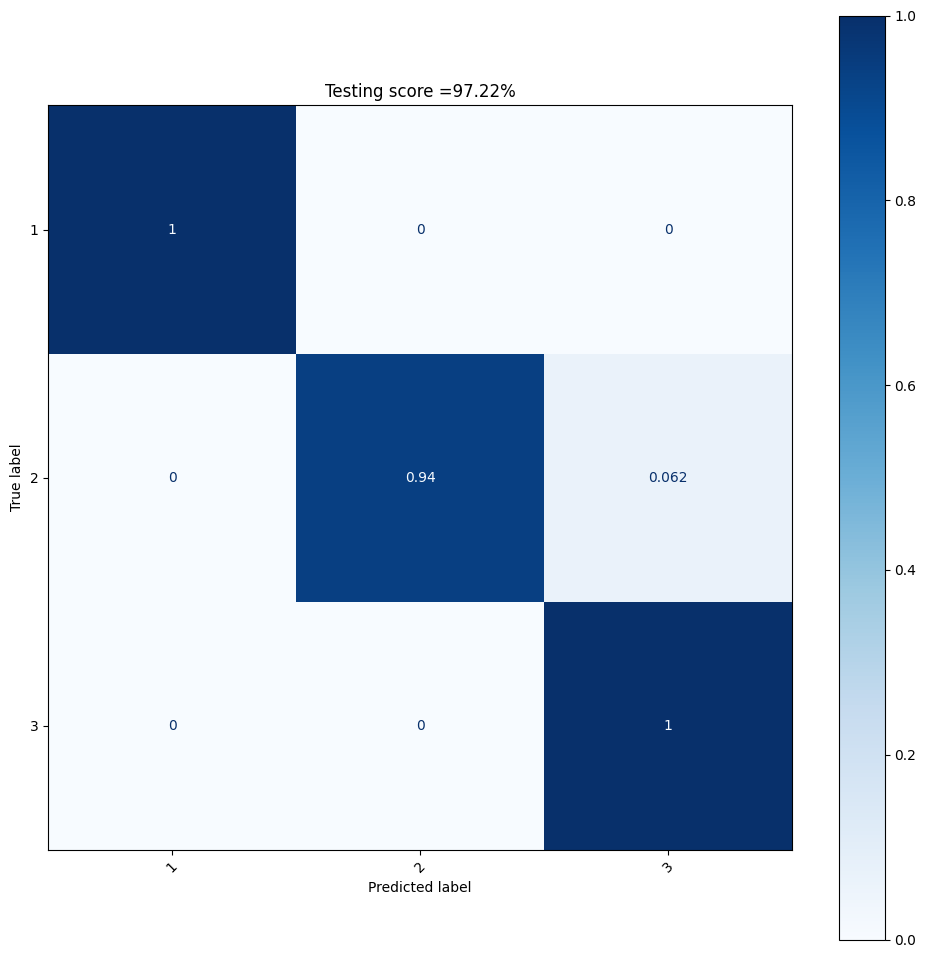

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12,12))
score = 100*clf_MLP.score(X_test_scaled, y_test)
title = 'Testing score ={:.2f}%'.format(score)
disp = ConfusionMatrixDisplay.from_estimator(
clf_MLP,
X_test_scaled,
y_test,
xticks_rotation=45, #’vertical’,
# display_labels=class_names,
cmap=plt.cm.Blues,
normalize='true',
ax = ax
)
disp.ax_.set_title(title)
plt.show()

In [13]:
# 主成分資料
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
# hidden_layers = (512,) # one hidden layer
# activation = ’relu’ # the default
hidden_layers = (30,)
activation = 'logistic'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = True, \
activation = activation, tol = 1e-6, max_iter = int(1e6))
# solver = ’sgd’ # not efficient, need more tuning
# solver = ’lbfgs’ # not suitable here
solver = 'adam' # default solver
clf_MLP = MLPClassifier(solver = solver, **opts)
clf_MLP.fit(X_train_pca, y_train)
predictions = clf_MLP.predict(X_test_pca)
print(classification_report(y_test, predictions))

Iteration 1, loss = 1.17598776
Iteration 2, loss = 1.16833226
Iteration 3, loss = 1.16084005
Iteration 4, loss = 1.15351582
Iteration 5, loss = 1.14636394
Iteration 6, loss = 1.13938836
Iteration 7, loss = 1.13259255
Iteration 8, loss = 1.12597940
Iteration 9, loss = 1.11955125
Iteration 10, loss = 1.11330991
Iteration 11, loss = 1.10725661
Iteration 12, loss = 1.10139198
Iteration 13, loss = 1.09571593
Iteration 14, loss = 1.09022757
Iteration 15, loss = 1.08492518
Iteration 16, loss = 1.07980620
Iteration 17, loss = 1.07486721
Iteration 18, loss = 1.07010399
Iteration 19, loss = 1.06551144
Iteration 20, loss = 1.06108366
Iteration 21, loss = 1.05681396
Iteration 22, loss = 1.05269487
Iteration 23, loss = 1.04871824
Iteration 24, loss = 1.04487531
Iteration 25, loss = 1.04115682
Iteration 26, loss = 1.03755315
Iteration 27, loss = 1.03405439
Iteration 28, loss = 1.03065055
Iteration 29, loss = 1.02733162
Iteration 30, loss = 1.02408776
Iteration 31, loss = 1.02090937
Iteration 32, los

### 輸出內容解析

這個輸出部分提供了MLP模型訓練過程的一些信息，以及最終的分類報告。讓我們分析一下：

1. **Iteration 1, loss = 1.07226324**:
   - 這個部分顯示了訓練的第一次迭代，並給出了該迭代的損失（loss）值。損失值是訓練過程中用來衡量模型預測與實際值之間差異的一個指標。

2. **Iteration 2, loss = 1.06394549**:
   - 類似於第一次迭代，這裡顯示了第二次迭代的損失值。

3. **...**:
   - 依次類推，這些輸出列出了每次迭代的損失值，直到訓練結束或達到最大迭代次數。

4. **accuracy**: 在最後的分類報告中，顯示了模型在測試數據上的準確率為0.97，即97%。

5. **macro avg**: 分類報告中的macro avg列顯示了各個指標（精確率、召回率、F1分數等）的平均值。在這裡，macro avg的值為0.97。

6. **weighted avg**: weighted avg列顯示了加權平均值，其中每個類別的權重由該類別在測試集中的樣本數決定。在這裡，加權平均準確率為0.97。

總的來說，這段輸出部分提供了模型訓練過程中損失的變化情況以及最終模型在測試數據上的表現。

 #### **畫出測試資料的confusion matrix**

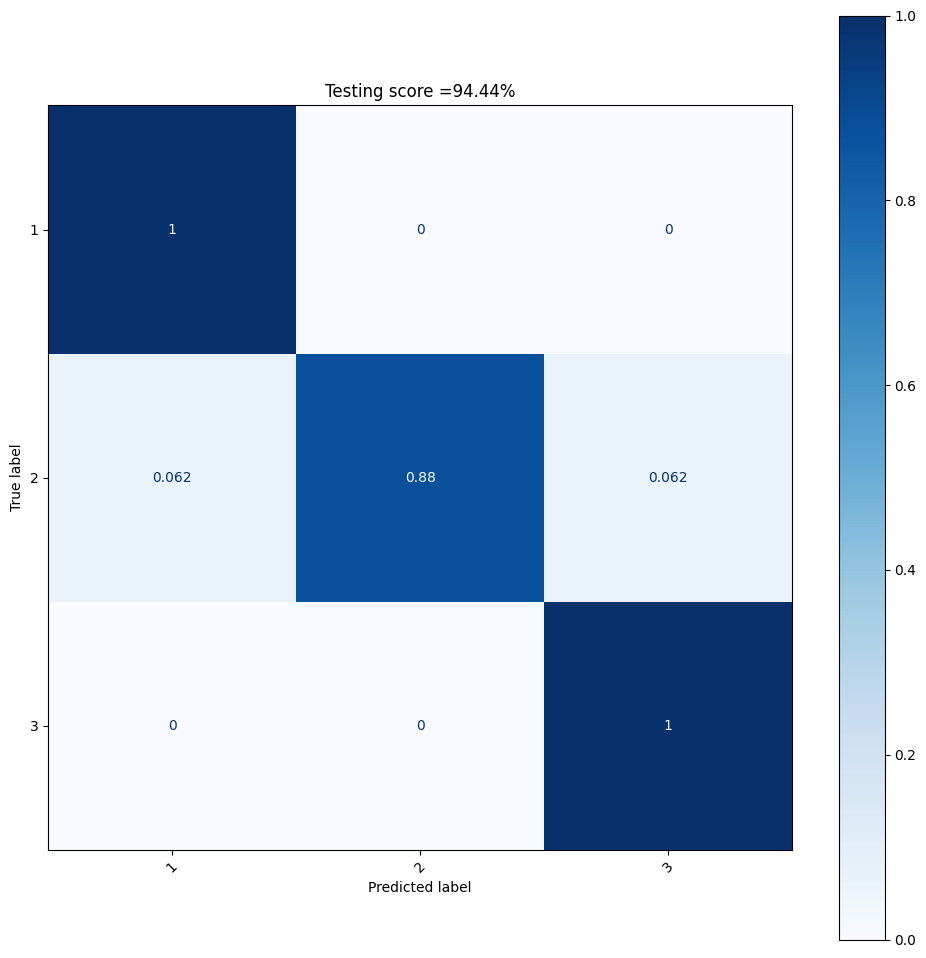

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12,12))
score = 100*clf_MLP.score(X_test_pca, y_test)
title = 'Testing score ={:.2f}%'.format(score)
disp = ConfusionMatrixDisplay.from_estimator(
clf_MLP,
X_test_pca,
y_test,
xticks_rotation=45, #’vertical’,
# display_labels=class_names,
cmap=plt.cm.Blues,
normalize='true',
ax = ax
)
disp.ax_.set_title(title)
plt.show()